# Binh and Korn function

---
Description:

- Optimization (min)
- Multi-objective (2)
- Constraints (2)
---


The goal is to **minimize** the following equations:

\begin{cases}
      f_{1}\left(x,y\right) = 4x^{2} + 4y^{2}, \\
      f_{2}\left(x,y\right) = \left(x - 5\right)^{2} + \left(y - 5\right)^{2} \\
\end{cases}

subject to constraints:

\begin{cases}
      C_{1}\left(x,y\right) = \left(x - 5\right)^{2} + y^{2} \leq 25, \\
      C_{2}\left(x,y\right) = \left(x - 8\right)^{2} + \left(y + 3\right)^{2} \geq 7.7 \\
\end{cases}

where:

\begin{cases}
      -15\le x \le 30, \\
      -15\le y \le 30. \\
\end{cases}

The Pareto-optimal solutions are constituted by solutions:
    $ x=y ∈ [0.0, 3.0] \text{  and  } x ∈ [3.0, 5.0], y=3.0.$

### First we import python libraries and set up the directory of our code.

In [12]:
import os, sys
import numpy as np
from math import fsum
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [13]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.engines.standard_ga import StandardGA
from pygenalgo.utils.utilities import cost_function, np_pareto_front

# Import Selection Operator(s).
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.random_mutator import RandomMutator

### Define the multi-objective function, which plays the role of the 'fitness' function.

We use a combination of the **weighted sum** and **penalty methods**.

In [14]:
# Multi-objective function.
@cost_function(minimize=True)
def fun_Binh_Korn(individual: Chromosome):
    
    # Set the penalty coefficient.
    rho = 5.0
    
    # Extract the data values as 'x' and 'y', for parsimony.
    x, y = individual.values()
    
    # Compute each objective function.
    f1 = 4.0 * (x**2 + y**2)
    f2 = (x - 5.0)**2 + (y - 5.0)**2
    
    # Compute the constraints.
    C1 = max(0.0, (x - 5.0)**2 + y**2 - 25.0)**2
    C2 = min(0.0, (x - 8.0)**2 + (y + 3.0)**2 - 7.7)**2
    
    # Compute the final value.
    f_value = fsum([0.5*f1, 0.5*f2, rho*(C1 + C2)])
    
    # Return the solution.
    return f_value
# _end_def_

Then we set the GA parameters, such as the genes, the number of chromosomes, etc. Note that in this case the genes have the same
range so we define a single random function, set by 'boundary_xy'. Moreover, we set the parameters for the GA engine.

In [15]:
# Random number generator.
rng = np.random.default_rng()

# Random function that enforce the boundaries in x/y.
boundary_xy = lambda: rng.uniform(-15.0, 30.0)

# Define the number of chromosomes.
n_pop = 100

# Draw random samples for the initial points.
xy_init = rng.uniform(-15.0, 30.0, size=(n_pop, 2))

# Initial population.
population = [Chromosome([Gene(xy_init[i, 0], boundary_xy),
                          Gene(xy_init[i, 1], boundary_xy)], np.nan, True)
              for i in range(n_pop)]

# Create the StandardGA object that will carry on the optimization.
test_GA = StandardGA(initial_pop=population,
                     fit_func=fun_Binh_Korn,
                     select_op=LinearRankSelector(),
                     mutate_op=RandomMutator(),
                     crossx_op=UniformCrossover())

### Optimization process.

Here we call the GA object (either directly, or through the method run()). We set a number of parameter, such as the maximum iterations (i.e. epochs), tolerance for the fitness convergences, etc.

In [16]:
test_GA(epochs=250, elitism=True, f_tol=1.0e-6, adapt_probs=True, verbose=False)

Initial Avg. Fitness = -1082121.5504
Final   Avg. Fitness = -65493.6042
Elapsed time: 1.944 seconds.


In [17]:
# Extract the data values as 'x' and 'y', for parsimony.
x, y = test_GA.best_chromosome().values()

# Compute the final objective functions.
f1_opt = 4.0 * (x**2 + y**2)
f2_opt = (x - 5.0)**2 + (y - 5.0)**2

# Print the results.
print(f"x={x:.5f}, y={y:.5f}", end='\n\n')
print(f"f1(x, y) = {f1_opt:.5f}")
print(f"f2(x, y) = {f2_opt:.5f}")

x=1.00201, y=1.00375

f1(x, y) = 8.04618
f2(x, y) = 31.95391


### Visualize the adapted probabilities.

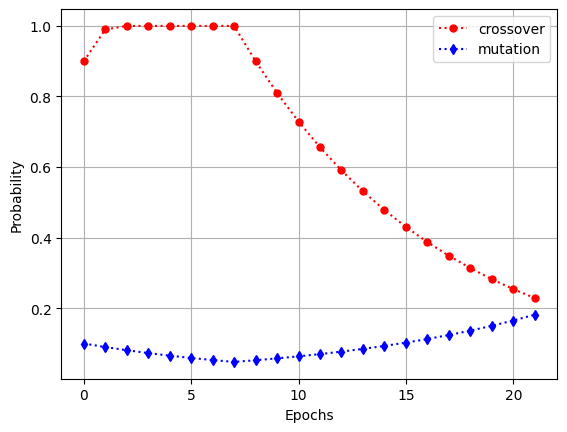

In [18]:
if len(test_GA.stats["prob_crossx"]) > 1:
    plt.plot(test_GA.stats["prob_crossx"],
             'ro:', markersize=5, label="crossover")

    plt.plot(test_GA.stats["prob_mutate"],
             'bd:', markersize=5, label="mutation")
    
    plt.xlabel("Epochs")
    plt.ylabel("Probability")
    plt.legend()
    
    plt.grid()

### Compute the Pareto Frontier (solutions).

In [19]:
# Create a list that will hold points that satisfy both constraints.
points = []

# Generate a 2D grid sample on [-15.0, 30].
for x in np.linspace(-15.0, 30.0, 100):
    
    for y in np.linspace(-15.0, 30.0, 100):
    
        # Compute the constraints.
        C1 = (x - 5.0)**2 + y**2 <= 25.0
        C2 = (x - 8.0)**2 + (y + 3.0)**2 >= 7.7

        # If both constraints are satisfied.
        if C1 and C2:

            # Evaluate both functions.
            f1 = 4.0 * (x**2 + y**2)
            f2 = (x - 5.0)**2 + (y - 5.0)**2

            # Keep the point in the list.
            points.append((f1, f2))
        # _end_if_
    # _end_for_
# _end_for_

In [20]:
# Convert lists to numpy.
points = np.array(points)

# Estimate the pareto front points.
pareto_points = np_pareto_front(points)

In [21]:
best_n = []

for p in test_GA.best_n(n=n_pop//2):
    # Extract the values.
    x, y = p.values()
    
    # Compute each objective function.
    f1 = 4.0 * (x**2 + y**2)
    f2 = (x - 5.0)**2 + (y - 5.0)**2

    # Add them to the list.
    best_n.append((f1, f2))

best_n = np.array(best_n)

### Visualize the solution on the Pareto plot.

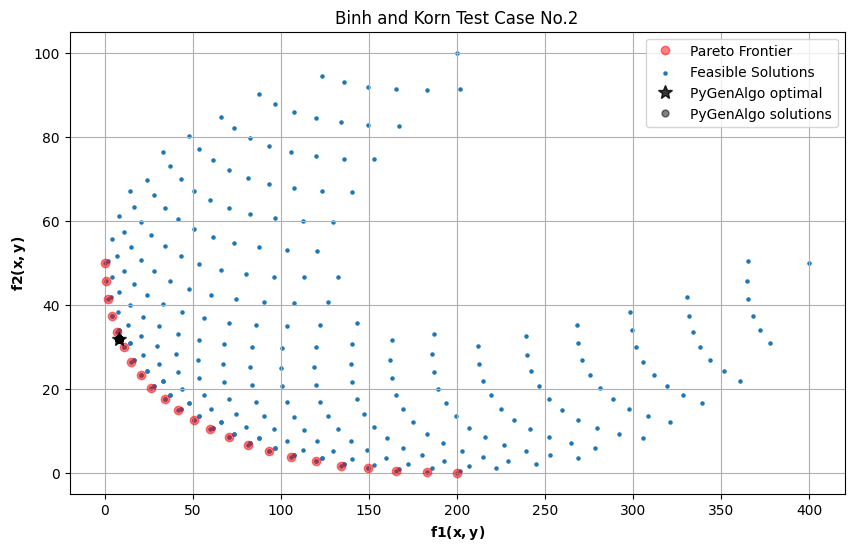

In [22]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.plot(pareto_points[:, 0],
         pareto_points[:, 1],
         'ro', alpha=0.5, label="Pareto Frontier")

# Plot all the feasible solutions.
plt.scatter(x=points[:, 0],
            y=points[:, 1],
            s=5, marker='o', label="Feasible Solutions")

# Plot the optimal solution from the GA.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="PyGenAlgo optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ko", alpha=0.5,
         markersize=5, label="PyGenAlgo solutions")

# Tidy up the plot.
plt.title("Binh and Korn Test Case No.2")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Binh_and_Korn_optimal.pdf", format="pdf", dpi=300)

### End of file